In [21]:
import matplotlib
import pandas
import sklearn
import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster

In [17]:
## Exercise a)
df = pandas.read_csv("data_ehr.csv")

df_isna = df.isna()

na_ratio = df_isna.mean()

df_clean = df.loc[:, na_ratio <= 0.30]

print("number dimensions before cleaning:", df.shape[1])
print("number of dimensions after cleaning:", df_clean.shape[1])
print("number of instances (patients):", df.shape[0])

number dimensions before cleaning: 130
number of dimensions after cleaning: 97
number of instances (patients): 1384


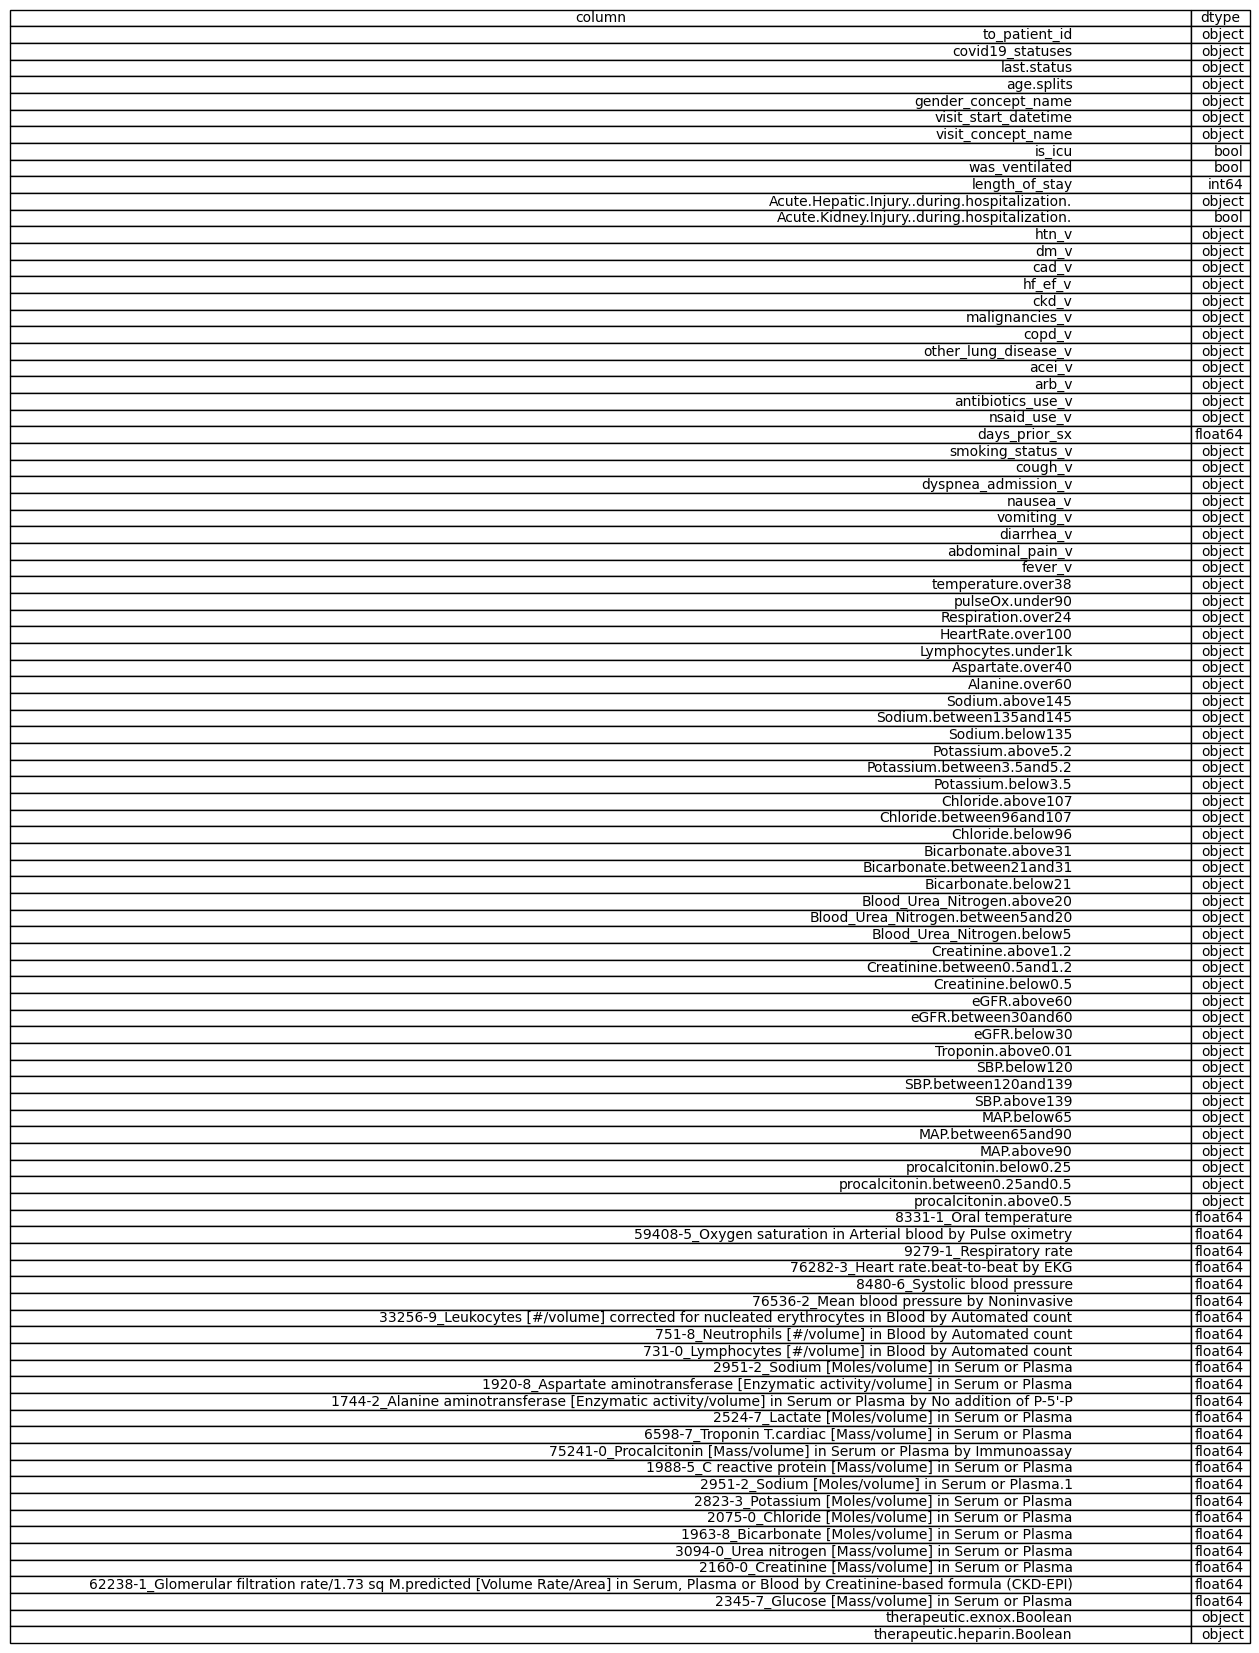

In [18]:
## Exercise b)

dtypes_df = df_clean.dtypes.to_frame("dtype").reset_index()
dtypes_df.columns = ["column", "dtype"]

fig, ax = plt.subplots(figsize=(1,0.1*len(dtypes_df)))
ax.axis("off")
table = ax.table(
    cellText=dtypes_df.values,
    colLabels=dtypes_df.columns,
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(dtypes_df.columns))))
plt.savefig("dtypes.png", bbox_inches="tight")

In [47]:
## Exercise c)
from sklearn.metrics import silhouette_score

#filtering only numerical features
df_only_num = df_clean.select_dtypes(include=[np.number])

#impute NaN values and scale
imp = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='median')
scaler = sklearn.preprocessing.StandardScaler()
X_imputed = imp.fit_transform(df_only_num)
X_scaled = scaler.fit_transform(X_imputed)

#kmeans with different k's
sil_scores = []
for k in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_scaled)
    labels = kmeans.labels_
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append({"k": k, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best k for kmeans
best = sil_df.loc[sil_df["silhouette"].idxmax()]
print(f"Best k for kmeans: {int(best.k)}, silhouette: {best.silhouette:.3f}")

#Agglomerative Clustering with different k's
sil_scores = []
for k in range(2, 11):
    ag = sklearn.cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ag.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append({"k": k, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best k for Agglomerative Clustering
best = sil_df.loc[sil_df["silhouette"].idxmax()]
print(f"Best k for AG: {int(best.k)}, silhouette: {best.silhouette:.3f}")


#Affinity Propagation with different dampings
sil_scores = []
for damping in np.arange(0.5, 1.0, 0.1):
    ap = sklearn.cluster.AffinityPropagation(damping=damping, random_state=0)
    labels = ap.fit_predict(X_scaled)
    # Silhouette braucht >=2 Cluster
    if len(set(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
    else:
        sil = np.nan
    sil_scores.append({"damping": damping, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best damping for Affinity Propagation
if sil_df["silhouette"].notna().any():
    best = sil_df.loc[sil_df["silhouette"].idxmax()]
    print(f"Best damping for Affinity Propagation: {best.damping:.1f}, silhouette: {best.silhouette:.3f}")
else:
    print("No valid silhouette for Affinity Propagation")


    k  silhouette
0   2    0.296750
1   3    0.158656
2   4    0.081990
3   5    0.095314
4   6    0.092942
5   7    0.085557
6   8    0.057188
7   9    0.055810
8  10    0.056496
Best k for kmeans: 2, silhouette: 0.297
    k  silhouette
0   2    0.285138
1   3    0.287896
2   4    0.104286
3   5    0.110010
4   6    0.117523
5   7    0.122923
6   8    0.127140
7   9    0.128635
8  10    0.132411
Best k for AG: 3, silhouette: 0.288
   damping  silhouette
0      0.5    0.037976
1      0.6    0.026841
2      0.7    0.027241
3      0.8    0.027241
4      0.9    0.036338
Best damping for Affinity Propagation: 0.5, silhouette: 0.038
